In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-11-28 13:00:33.122942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 13:00:33.122971: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =3

warmup_start = '20210428'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
learning_rate = 1e-4

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [5]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [7]:
warmup_A_params = {}
warmup_A_params[Vax.total.value] = {}
warmup_A_params[Vax.total.value]['prior'] = []
warmup_A_params[Vax.total.value]['posterior_init'] = []

for day in range(transition_window):
    warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                'scale': warmup_asymp[day]/10})
    

In [8]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'mild'], dtype=tf.float32)

2021-11-28 13:00:36.166749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-28 13:00:36.166943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 13:00:36.167057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-28 13:00:36.167091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-28 13:00:36.167119: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_A_params[-1]['prior'][day]['loc'])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [10]:

T_serial = {}
T_serial[Vax.total.value] = {}
T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}


rho_M = {}
rho_M[Vax.total.value] = {}
rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}

lambda_M = {}
lambda_M[Vax.total.value] = {}
lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}

nu_M = {}
nu_M[Vax.total.value] = {}
nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}




In [11]:
variance_scales = np.logspace(-2,2,20)

In [12]:
T_serial_scale = 1.0
rho_M_scale = 0.1
lambda_M_scale = 1.0
nu_M_scale = 1.2

warmup_scales = [0.1, 0.1, 0.1]

In [13]:
 
T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_T_serial),
                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}

rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(synth_rho_M/(1-synth_rho_M)),dtype=tf.float32),
                                      'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(synth_lambda_M),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}

nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(synth_nu_M),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

for day in range(transition_window):
    # must be positive so reverse softplus the mean
    warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]),dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(warmup_scales[day]),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

model = CovidModel([Vax.total], [Comp.A, Comp.M],
                 transition_window,
                T_serial, rho_M, lambda_M, nu_M,
                 warmup_A_params, posterior_samples=1000)

loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)

with tf.GradientTape() as tape:
    model._constrain_parameters()
    model._sample_and_reparameterize()
    model._add_prior_loss()
    loss_val = sum(model.losses)

2021-11-28 13:00:39.999605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
model.prior_distros[Comp.A.value][Vax.total.value]['T_serial'].log_prob(model.T_serial_samples_constrained) * \
            tfp.bijectors.Softplus().forward_log_det_jacobian(model.T_serial_samples)

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([0.00320798, 0.0016924 , 0.00160764, 0.0037411 , 0.00128891,
       0.00180637, 0.01043028, 0.00461111, 0.02900842, 0.00255158,
       0.00193563, 0.00248061, 0.00977321, 0.02118883, 0.00138415,
       0.00193519, 0.00566968, 0.00189651, 0.00607954, 0.00110996,
       0.020037  , 0.00179236, 0.00679844, 0.00173156, 0.02046168,
       0.00167022, 0.01392751, 0.00173434, 0.00203524, 0.01990518,
       0.00490954, 0.00516279, 0.01143054, 0.00330223, 0.00147158,
       0.00307373, 0.00093572, 0.00169794, 0.00194961, 0.02054852,
       0.00371036, 0.00174231, 0.00194491, 0.01593264, 0.00491991,
       0.00116697, 0.0020095 , 0.00193957, 0.00251687, 0.0232062 ,
       0.00146291, 0.00485005, 0.02051196, 0.04766069, 0.00215334,
       0.01904963, 0.00208255, 0.00343885, 0.00278588, 0.00300163,
       0.00190855, 0.00121293, 0.00436689, 0.00434094, 0.04340627,
       0.0019382 , 0.00308012, 0.01188677, 0.00670017, 0.00164355,
       0.0041

In [15]:
alternative_T_serial_prior = scipy.stats.norm(5.8,1)

In [16]:
u_Tserial_range = np.linspace(1e-8,10,1000)

In [17]:
prior_probabilities_from_model = model.prior_distros[Comp.A.value][Vax.total.value]['T_serial'].log_prob(u_Tserial_range) * \
            tfp.bijectors.Softplus().forward_log_det_jacobian(
            tf.cast(tfp.bijectors.Softplus().inverse(u_Tserial_range),
                    dtype=tf.float32)
)

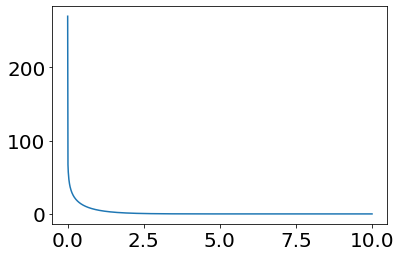

In [18]:
plt.plot(u_Tserial_range, prior_probabilities_from_model)

In [19]:
alternative_log_probs = alternative_T_serial_prior.logpdf(u_Tserial_range)
unconstrained_thetas = np.log(np.exp(u_Tserial_range) - 1.)
jacobian_adjustment = np.exp(unconstrained_thetas)/(1+np.exp(unconstrained_thetas))
prior_probabilities_hand_calc = alternative_log_probs +  np.log(jacobian_adjustment)

Text(0.5, 1.0, 'Prior Probability vs T_serial')

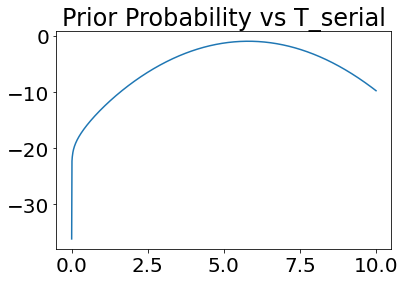

In [20]:
plt.plot(u_Tserial_range, prior_probabilities_hand_calc)
plt.title('Prior Probability vs T_serial')

Text(0.5, 1.0, 'Transformed Prior Likelihood vs T_serial')

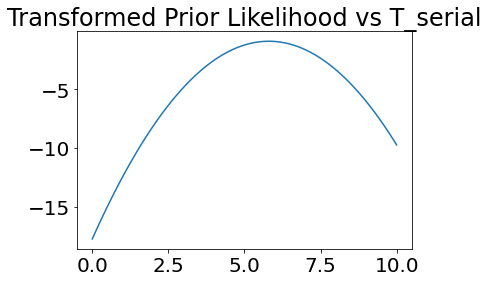

In [21]:
plt.plot(u_Tserial_range,alternative_log_probs)
plt.title('Transformed Prior Likelihood vs T_serial')

In [54]:
model.prior_distros[Comp.A.value][Vax.total.value]['T_serial'].log_prob(theta_range)

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([-14.65206   , -14.621454  , -14.590776  , -14.560017  ,
       -14.529182  , -14.49827   , -14.467283  , -14.43622   ,
       -14.405084  , -14.373873  , -14.342586  , -14.311224  ,
       -14.279793  , -14.248287  , -14.216707  , -14.185059  ,
       -14.153337  , -14.121544  , -14.08968   , -14.057748  ,
       -14.025746  , -13.993673  , -13.961534  , -13.929325  ,
       -13.89705   , -13.864708  , -13.832301  , -13.799825  ,
       -13.767288  , -13.734682  , -13.702014  , -13.669282  ,
       -13.636489  , -13.603631  , -13.570712  , -13.537731  ,
       -13.50469   , -13.471591  , -13.438429  , -13.40521   ,
       -13.371934  , -13.338596  , -13.305206  , -13.271757  ,
       -13.238253  , -13.204693  , -13.171077  , -13.137412  ,
       -13.103689  , -13.069917  , -13.036091  , -13.0022135 ,
       -12.968287  , -12.934309  , -12.900284  , -12.866207  ,
       -12.832086  , -12.797914  , -12.763698  , -12.729437  ,
      

In [55]:
alternative_log_probs

array([-17.73893848, -17.68093052, -17.62302276, -17.5652152 ,
       -17.50750785, -17.44990069, -17.39239373, -17.33498698,
       -17.27768042, -17.22047407, -17.16336791, -17.10636196,
       -17.0494562 , -16.99265065, -16.93594529, -16.87934014,
       -16.82283519, -16.76643043, -16.71012588, -16.65392153,
       -16.59781738, -16.54181343, -16.48590967, -16.43010612,
       -16.37440277, -16.31879962, -16.26329667, -16.20789392,
       -16.15259137, -16.09738902, -16.04228687, -15.98728492,
       -15.93238318, -15.87758163, -15.82288028, -15.76827913,
       -15.71377819, -15.65937744, -15.60507689, -15.55087655,
       -15.4967764 , -15.44277645, -15.38887671, -15.33507716,
       -15.28137782, -15.22777867, -15.17427973, -15.12088099,
       -15.06758244, -15.0143841 , -14.96128596, -14.90828801,
       -14.85539027, -14.80259273, -14.74989539, -14.69729824,
       -14.6448013 , -14.59240456, -14.54010802, -14.48791168,
       -14.43581554, -14.3838196 , -14.33192386, -14.28